In [56]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

pwd = os.getcwd()

## Table of Contents
* [Helper Functions](#helperfunctions)
* [Dataset Exploration](#datasetexploration)
    * [Nested Data Structure](#nested)
    * [Unique Values For Days, IDs, Rounds & Signals](#unique)
    * [Summary Statistics](#summarystats)
    * [Missing Values](#missing)
* [EDA](#eda)
    * [Biosignal Distribution](#biosignaldist)
    * [Biosignal Statistics](#biosignalstats)
    * [Biosignal Correlations](#biosignalcorr)
* [Data Preprocessing](#datapreprocessing)
    * [Assigning Unique IDs and Team IDs](#uniqueid)
    * [Extract Numerical Features](#extractnumericalfeatures)
    * [Standardizing Numerical Data](#standardizing)
* [Unsupervised Machine Learning](#unsupervised)
    * [K-means Clustering](#kmeans)


## Helper Functions <a class="anchor" id="helperfunctions"></a>

In [57]:
# Functions that will help us import the data

"""def load_csv_data(folder_path, file_name):
    file_path = f"{folder_path}/{file_name}"
    return pd.read_csv(file_path)"""

def load_csv_data(phase_path, file_name):
    file_path = os.path.join(phase_path, file_name)
    if not os.path.exists(file_path):
        return None
    data = pd.read_csv(file_path)
    return convert_time_to_datetime(data)

def load_excel_data(folder_path, file_name):
    file_path = f"{folder_path}/{file_name}"
    return pd.read_excel(file_path)

# convert the 'time' column to a datetime object and set it as the index
def convert_time_to_datetime(data):
    if 'time' not in data.columns:
        return data
    if data['time'].dtype == 'datetime64[ns]':
        return data.set_index('time')
    return data.set_index(pd.to_datetime(data['time']))

# resample the data at a common frequency
def resample_data(data, frequency='S'):
    if data is None:
        return None
    return data.resample(frequency).mean().interpolate(method='linear')

In [58]:
def combine_data(data_path):
    combined_data = []
    
    for day_folder in sorted(os.listdir(data_path)):
        day_path = os.path.join(data_path, day_folder)
        if not os.path.isdir(day_path):
            continue
            
        if day_folder == "D1_3":
            for d1_3_subfolder in sorted(os.listdir(day_path)):
                d1_3_subfolder_path = os.path.join(day_path, d1_3_subfolder)
                if not os.path.isdir(d1_3_subfolder_path):
                    continue
                
                for id_folder in sorted(os.listdir(d1_3_subfolder_path)):
                    process_id_folder(d1_3_subfolder_path, id_folder, combined_data)
        else:
            for id_folder in sorted(os.listdir(day_path)):
                process_id_folder(day_path, id_folder, combined_data)
                
    return combined_data

def process_id_folder(day_path, id_folder, combined_data):
    id_path = os.path.join(day_path, id_folder)
    if not os.path.isdir(id_path):
        return

    for round_folder in sorted(os.listdir(id_path)):
        round_path = os.path.join(id_path, round_folder)
        if not os.path.isdir(round_path):
            continue

        for phase_folder in sorted(os.listdir(round_path)):
            phase_path = os.path.join(round_path, phase_folder)
            if not os.path.isdir(phase_path):
                continue

            bvp_data = resample_data(load_csv_data(phase_path, "BVP.csv"))
            eda_data = resample_data(load_csv_data(phase_path, "EDA.csv"))
            hr_data = resample_data(load_csv_data(phase_path, "HR.csv"))
            temp_data = resample_data(load_csv_data(phase_path, "TEMP.csv"))
            response_data = load_csv_data(phase_path, "response.csv")

            combined_data.append({
                'day': os.path.split(day_path)[-1],
                'id': os.path.split(id_path)[-1],
                'round': os.path.split(round_path)[-1],
                'phase': os.path.split(phase_path)[-1],
                'bvp': bvp_data,
                'eda': eda_data,
                'hr': hr_data,
                'temp': temp_data,
                'response': response_data
            })

data_path = os.path.join(pwd, 'dataset_withTeams')
combined_data = combine_data(data_path)
combined_dataframe = pd.DataFrame.from_records(combined_data)


In [59]:
# This is a modified version of the process_id_folder to identify missing data for ID_4
def process_id_folder(day_path, id_folder, combined_data):
    id_path = os.path.join(day_path, id_folder)
    if not os.path.isdir(id_path):
        return

    for round_folder in sorted(os.listdir(id_path)):
        round_path = os.path.join(id_path, round_folder)
        if not os.path.isdir(round_path):
            continue

        for phase_folder in sorted(os.listdir(round_path)):
            phase_path = os.path.join(round_path, phase_folder)
            if not os.path.isdir(phase_path):
                continue

            if id_folder == "ID_4":
                print(f"Day: {os.path.split(day_path)[-1]}, ID: {id_folder}, Round: {os.path.split(round_path)[-1]}, Phase: {os.path.split(phase_path)[-1]}")

            bvp_data = resample_data(load_csv_data(phase_path, "BVP.csv"))
            eda_data = resample_data(load_csv_data(phase_path, "EDA.csv"))
            hr_data = resample_data(load_csv_data(phase_path, "HR.csv"))
            temp_data = resample_data(load_csv_data(phase_path, "TEMP.csv"))
            response_data = load_csv_data(phase_path, "response.csv")

            combined_data.append({
                'day': os.path.split(day_path)[-1],
                'id': os.path.split(id_path)[-1],
                'round': os.path.split(round_path)[-1],
                'phase': os.path.split(phase_path)[-1],
                'bvp': bvp_data,
                'eda': eda_data,
                'hr': hr_data,
                'temp': temp_data,
                'response': response_data
            })

combined_data_ = combine_data(data_path)
#combined_dataframe_ = pd.DataFrame.from_records(combined_data)


Day: D1_1, ID: ID_4, Round: round_1, Phase: phase1
Day: D1_1, ID: ID_4, Round: round_1, Phase: phase2
Day: D1_1, ID: ID_4, Round: round_1, Phase: phase3
Day: D1_1, ID: ID_4, Round: round_2, Phase: phase1
Day: D1_1, ID: ID_4, Round: round_2, Phase: phase2
Day: D1_1, ID: ID_4, Round: round_2, Phase: phase3
Day: D1_1, ID: ID_4, Round: round_3, Phase: phase1
Day: D1_1, ID: ID_4, Round: round_3, Phase: phase2
Day: D1_1, ID: ID_4, Round: round_3, Phase: phase3
Day: D1_1, ID: ID_4, Round: round_4, Phase: phase1
Day: D1_1, ID: ID_4, Round: round_4, Phase: phase2
Day: D1_1, ID: ID_4, Round: round_4, Phase: phase3
Day: D1_2, ID: ID_4, Round: round_1, Phase: phase1
Day: D1_2, ID: ID_4, Round: round_1, Phase: phase2
Day: D1_2, ID: ID_4, Round: round_1, Phase: phase3
Day: D1_2, ID: ID_4, Round: round_2, Phase: phase1
Day: D1_2, ID: ID_4, Round: round_2, Phase: phase2
Day: D1_2, ID: ID_4, Round: round_2, Phase: phase3
Day: D1_2, ID: ID_4, Round: round_3, Phase: phase1
Day: D1_2, ID: ID_4, Round: rou

## Explore the DataSet <a class="anchor" id="datasetexploration"></a>

>### Nested Data Structure <a class="anchor" id="nested"></a>
- dataset
    - day (D1_1, D1_2, D1_3)
        - ID (ID_1, ID_2, ID_3, ...)
            - round (round1, round2, round3, round4)
                - phase (phase1, phase2, phase3)
                    - BVP.csv
                    - EDA.csv
                    - HR.csv
                    - TEMP.csv
                    - response.csv

In [60]:
combined_dataframe.head()

,day,id,round,phase,bvp,eda,hr,temp,response
0,D1_1,ID_1,round_1,phase1,Unnamed: 0 BVP ti...,Unnamed: 0 EDA time...,Unnamed: 0 HR time ...,Unnamed: 0 TEMP time ...,Unnamed: 0 particpant_ID puzzler team_ID...
1,D1_1,ID_1,round_1,phase2,Unnamed: 0 BVP ti...,Unnamed: 0 EDA time...,Unnamed: 0 HR time ...,Unnamed: 0 TEMP time ...,Unnamed: 0 particpant_ID puzzler team_ID...
2,D1_1,ID_1,round_1,phase3,Unnamed: 0 BVP tim...,Unnamed: 0 EDA time...,Unnamed: 0 HR time ...,Unnamed: 0 TEMP time ...,Unnamed: 0 particpant_ID puzzler team_ID...
3,D1_1,ID_1,round_2,phase1,Unnamed: 0 BVP tim...,Unnamed: 0 EDA time...,Unnamed: 0 HR time ...,Unnamed: 0 TEMP time ...,Unnamed: 0 particpant_ID puzzler team_ID...
4,D1_1,ID_1,round_2,phase2,Unnamed: 0 BVP tim...,Unnamed: 0 EDA time...,Unnamed: 0 HR time ...,Unnamed: 0 TEMP time ...,Unnamed: 0 particpant_ID puzzler team_ID...


In [61]:
# Example on how to grab specific instance
combined_dataframe.iloc[17,-2]

,Unnamed: 0,TEMP
time,,
2021-12-17 16:56:31,0.0,32.41
2021-12-17 16:56:32,2.5,32.39
2021-12-17 16:56:33,6.5,32.41
2021-12-17 16:56:34,10.5,32.39
2021-12-17 16:56:35,14.5,32.41
...,...,...
2021-12-17 17:02:00,1314.5,32.34
2021-12-17 17:02:01,1318.5,32.37
2021-12-17 17:02:02,1322.5,32.37


In [62]:
print(f"type(combined_dataframe): {type(combined_dataframe)}")
print(f"combined_dataframe.shape: {combined_dataframe.shape}")

type(combined_dataframe): <class 'pandas.core.frame.DataFrame'>
combined_dataframe.shape: (312, 9)


>### Unique Values For Days, IDs, Rounds & Signals <a class="anchor" id="unique"></a>


In [63]:
print("Unique days:", combined_dataframe['day'].unique())
print("Unique IDs:", combined_dataframe['id'].unique())
print("Unique rounds:", combined_dataframe['round'].unique())
print("Unique phases:", combined_dataframe['phase'].unique())

Unique days: ['D1_1' 'D1_2' 'D1_3_1' 'D1_3_2' 'D1_3_3' 'D1_3_4']
Unique IDs: ['ID_1' 'ID_2' 'ID_3' 'ID_4' 'ID_5' 'ID_6' 'ID_7' 'ID_8']
Unique rounds: ['round_1' 'round_2' 'round_3' 'round_4']
Unique phases: ['phase1' 'phase2' 'phase3']


>### Summary Statistics <a class="anchor" id="summarystats"></a>


In [64]:
# This takes too long (hours per line) to run

"""
def summary_statistics(combined_dataframe, column_name):
    data_list = combined_dataframe[column_name].apply(lambda x: x.values).explode().dropna()
    return data_list.describe()

print("\nBVP summary statistics:\n", summary_statistics(combined_dataframe, 'bvp'))
print("\nEDA summary statistics:\n", summary_statistics(combined_dataframe, 'eda'))
print("\nHR summary statistics:\n", summary_statistics(combined_dataframe, 'hr'))
print("\nTEMP summary statistics:\n", summary_statistics(combined_dataframe, 'temp'))
print("\nResponse summary statistics:\n", summary_statistics(combined_dataframe, 'response'))
"""

'\ndef summary_statistics(combined_dataframe, column_name):\n    data_list = combined_dataframe[column_name].apply(lambda x: x.values).explode().dropna()\n    return data_list.describe()\n\nprint("\nBVP summary statistics:\n", summary_statistics(combined_dataframe, \'bvp\'))\nprint("\nEDA summary statistics:\n", summary_statistics(combined_dataframe, \'eda\'))\nprint("\nHR summary statistics:\n", summary_statistics(combined_dataframe, \'hr\'))\nprint("\nTEMP summary statistics:\n", summary_statistics(combined_dataframe, \'temp\'))\nprint("\nResponse summary statistics:\n", summary_statistics(combined_dataframe, \'response\'))\n'

>### Missing Values <a class="anchor" id="missing"></a>


In [65]:
print("\nMissing values:\n", combined_dataframe.isnull().sum())


Missing values:
 day         0
id          0
round       0
phase       0
bvp         0
eda         0
hr          0
temp        0
response    0
dtype: int64


In [66]:
def nested_missing_values(data, column_name):
    missing_count = 0
    for nested_data in data[column_name]:
        if nested_data is not None:
            missing_count += nested_data.isna().sum().sum()
    return missing_count

print("\nMissing values in BVP nested data:", nested_missing_values(combined_dataframe, 'bvp'))
print("Missing values in EDA nested data:", nested_missing_values(combined_dataframe, 'eda'))
print("Missing values in HR nested data:", nested_missing_values(combined_dataframe, 'hr'))
print("Missing values in TEMP nested data:", nested_missing_values(combined_dataframe, 'temp'))
print("Missing values in Response nested data:", nested_missing_values(combined_dataframe, 'response'))


Missing values in BVP nested data: 0
Missing values in EDA nested data: 0
Missing values in HR nested data: 0
Missing values in TEMP nested data: 0
Missing values in Response nested data: 28


## EDA <a class="anchor" id="eda"></a>


>### Biosignal Distribution
<a class="anchor" id="biosignaldist"></a>

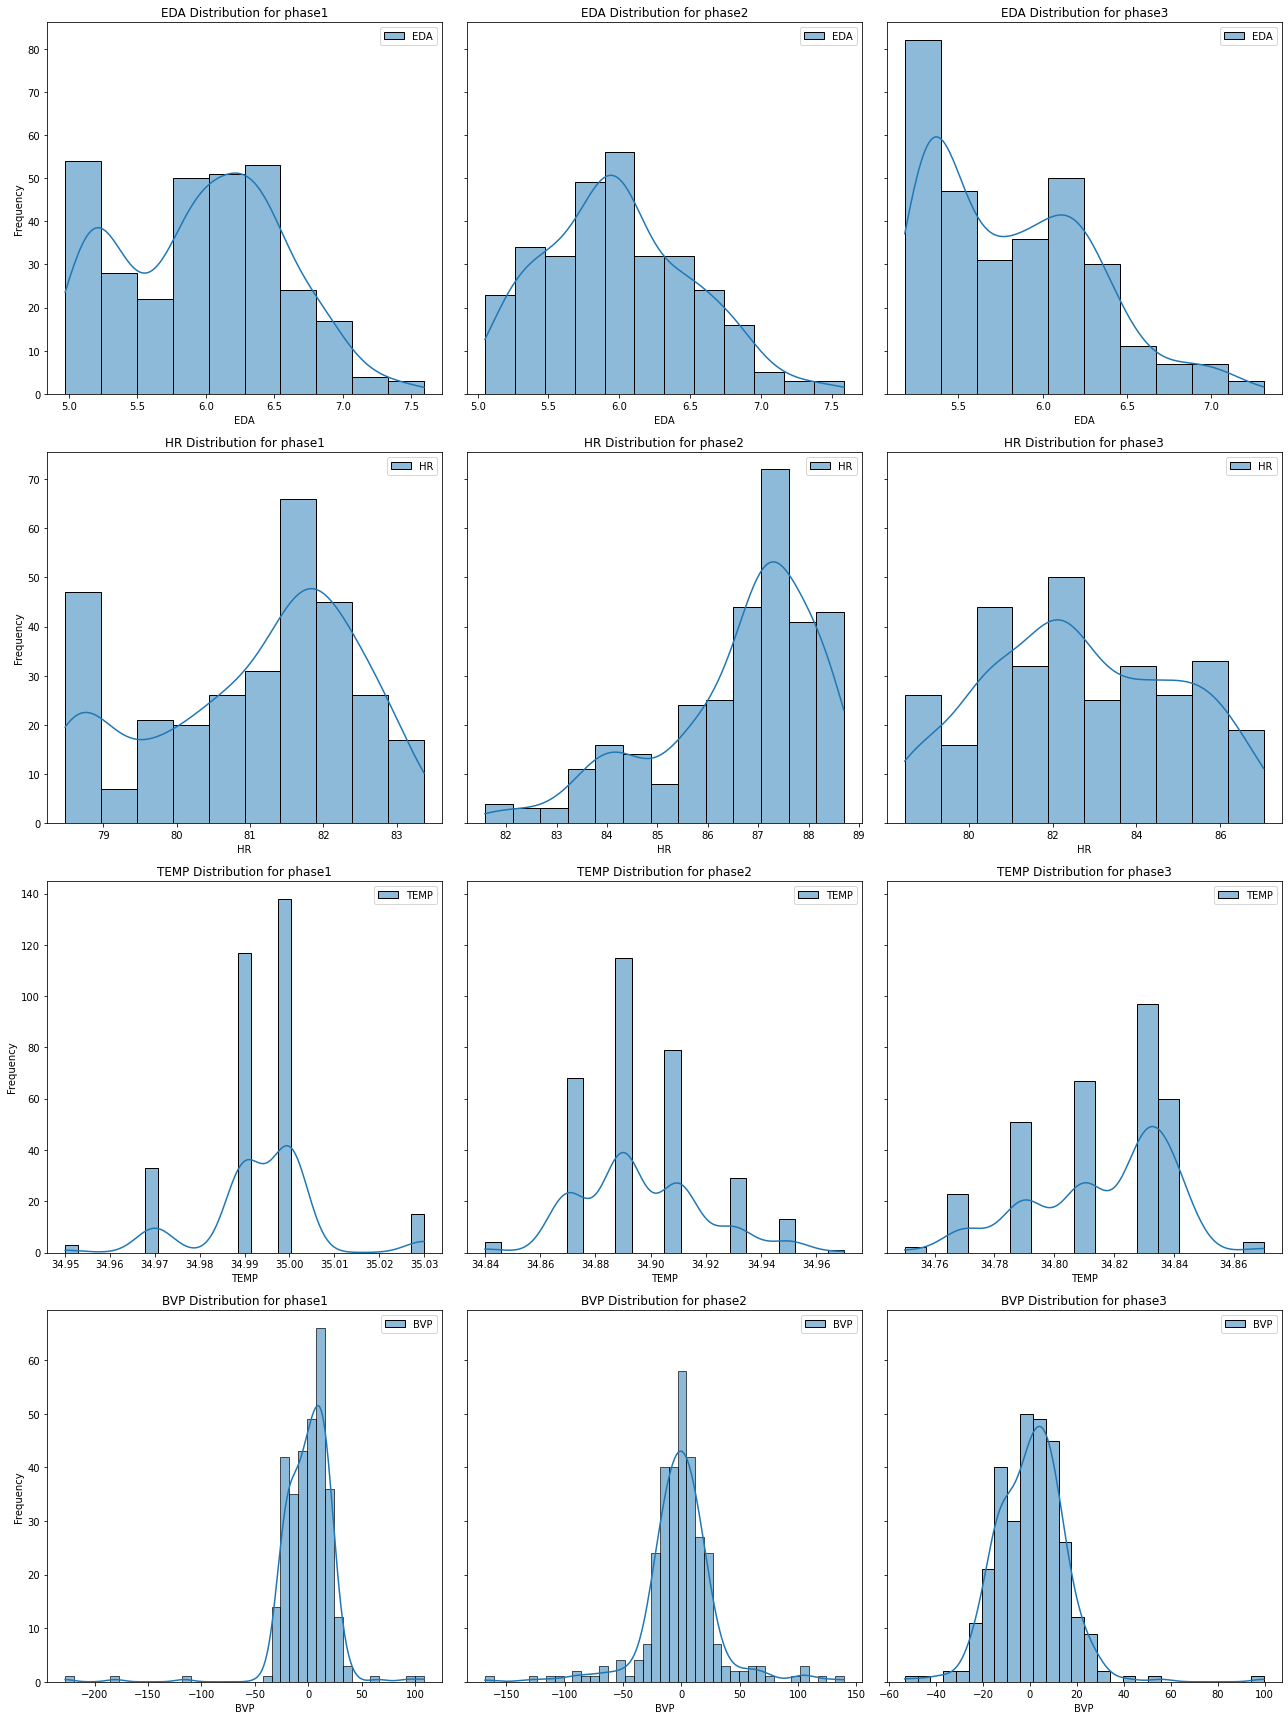

In [67]:
biosignals = ['EDA', 'HR', 'TEMP', 'BVP']
num_biosignals = len(biosignals)
fig, axs = plt.subplots(num_biosignals, 3, figsize=(18, 6*num_biosignals), sharey='row')

for b_idx, biosignal in enumerate(biosignals):
    for p_idx, phase in enumerate(['phase1', 'phase2', 'phase3']):
        phase_data = combined_dataframe[combined_dataframe['phase'] == phase]
        signal_data = [row[biosignal] for row in phase_data[biosignal.lower()]]
        sns.histplot(signal_data, kde=True, ax=axs[b_idx, p_idx])
        axs[b_idx, p_idx].set_title(f"{biosignal} Distribution for {phase}")
        axs[b_idx, p_idx].set_xlabel(biosignal)
        axs[b_idx, p_idx].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

>### Biosignal Statistics
<a class="anchor" id="biosignalstats"></a>

In [68]:
biosignals = ['EDA', 'HR', 'TEMP', 'BVP']
phases = ['phase1', 'phase2', 'phase3']
summary_stats = []

for biosignal in biosignals:
    for phase in phases:
        phase_data = combined_dataframe[combined_dataframe['phase'] == phase]
        signal_data = [row[biosignal] for row in phase_data[biosignal.lower()]]
        combined_signal_data = pd.concat(signal_data)
        
        mean = combined_signal_data.mean()
        median = combined_signal_data.median()
        std_dev = combined_signal_data.std()
        
        summary_stats.append({
            'biosignal': biosignal,
            'phase': phase,
            'mean': mean,
            'median': median,
            'std_dev': std_dev
        })

summary_stats_df = pd.DataFrame(summary_stats)
print(summary_stats_df)

   biosignal   phase       mean     median    std_dev
0        EDA  phase1   3.826491   1.676197   5.162683
1        EDA  phase2   3.981205   1.937163   5.534160
2        EDA  phase3   4.658661   2.115972   6.615961
3         HR  phase1  78.341019  75.300000  16.429139
4         HR  phase2  79.755551  77.930000  11.580398
5         HR  phase3  77.272981  74.920000  13.110870
6       TEMP  phase1  32.838585  32.830000   1.633999
7       TEMP  phase2  32.933616  32.870000   1.644672
8       TEMP  phase3  32.914380  32.810000   1.664216
9        BVP  phase1   0.019101   0.080000  32.691688
10       BVP  phase2  -0.017364   0.181875  41.962876
11       BVP  phase3  -0.057368   0.108906  40.401971


>### Biosignal Correlation
<a class="anchor" id="biosignalcorr"></a>

In [69]:
measures = ['bvp', 'eda', 'hr', 'temp']
mean_correlations = {}

for phase in ['phase1', 'phase2', 'phase3']:
    phase_data = combined_dataframe[combined_dataframe['phase'] == phase]
    
    for measure1 in measures:
        for measure2 in measures:
            if measure1 == measure2:
                continue
            
            pair_key = f"{measure1}-{measure2}"
            if pair_key in mean_correlations:
                continue
            
            reverse_pair_key = f"{measure2}-{measure1}"
            correlations = []
            
            for index, row in phase_data.iterrows():
                data1 = row[measure1][measure1.upper()]
                data2 = row[measure2][measure2.upper()]

                # Resample the data1 to match the data2 length
                data1_resampled = np.interp(np.linspace(0, len(data1), len(data2)), np.arange(len(data1)), data1)

                # Calculate the correlation coefficient
                corr = np.corrcoef(data1_resampled, data2)[0, 1]
                correlations.append(corr)
                
            mean_correlations[pair_key] = np.mean(correlations)
            print(f"Mean correlation between {measure1.upper()} and {measure2.upper()} for {phase}: {mean_correlations[pair_key]}")

Mean correlation between BVP and EDA for phase1: -0.013032454916971482
Mean correlation between BVP and HR for phase1: -0.0068422116767544805
Mean correlation between BVP and TEMP for phase1: -0.003857129746873263
Mean correlation between EDA and BVP for phase1: -0.006118958447697494
Mean correlation between EDA and HR for phase1: 0.08368629399885032
Mean correlation between EDA and TEMP for phase1: 0.05256337760861419
Mean correlation between HR and BVP for phase1: -0.003207713738792292
Mean correlation between HR and EDA for phase1: 0.08492135562946991
Mean correlation between HR and TEMP for phase1: 0.03526917039564726
Mean correlation between TEMP and BVP for phase1: -0.0008830618680065367
Mean correlation between TEMP and EDA for phase1: 0.05302459880535567
Mean correlation between TEMP and HR for phase1: 0.03558995872417467


## Data Preprocessing <a class="anchor" id="datapreprocessing"></a>


>### Assigning Unique IDs and Team IDs <a class="anchor" id="uniqueid"></a>

In [70]:
combined_dataframe['unique_id'] = combined_dataframe['day'] + '_' + combined_dataframe['id']
print(f"Distinct IDs: {len(combined_dataframe.unique_id.value_counts())}, \n{combined_dataframe.unique_id.value_counts()}")

Distinct IDs: 26, 
D1_1_ID_1      12
D1_1_ID_2      12
D1_3_4_ID_1    12
D1_3_3_ID_2    12
D1_3_3_ID_1    12
D1_3_2_ID_4    12
D1_3_2_ID_3    12
D1_3_2_ID_2    12
D1_3_2_ID_1    12
D1_3_1_ID_4    12
D1_3_1_ID_3    12
D1_3_1_ID_2    12
D1_3_1_ID_1    12
D1_2_ID_6      12
D1_2_ID_5      12
D1_2_ID_4      12
D1_2_ID_3      12
D1_2_ID_2      12
D1_2_ID_1      12
D1_1_ID_8      12
D1_1_ID_7      12
D1_1_ID_6      12
D1_1_ID_5      12
D1_1_ID_4      12
D1_1_ID_3      12
D1_3_4_ID_2    12
Name: unique_id, dtype: int64


>### Extract Numerical Features <a class="anchor" id="extractnumericalfeatures"></a>

In [18]:
def combine_biodata(bvp, eda, hr, temp):
    return pd.concat([bvp, eda, hr, temp], axis=1)

combined_dataframe['combined_biodata'] = combined_dataframe.apply(lambda row: combine_biodata(row['bvp'], row['eda'], row['hr'], row['temp']), axis=1)
combined_dataframe['combined_biodata'].head()

0                         Unnamed: 0         BVP  U...
1                         Unnamed: 0         BVP  U...
2                         Unnamed: 0        BVP  Un...
3                         Unnamed: 0        BVP  Un...
4                         Unnamed: 0        BVP  Un...
Name: combined_biodata, dtype: object

In [20]:
def extract_features(combined_biodata):
    features = {
        'bvp_mean': combined_biodata['BVP'].mean(),
        'bvp_std': combined_biodata['BVP'].std(),
        'bvp_min': combined_biodata['BVP'].min(),
        'bvp_max': combined_biodata['BVP'].max(),
        'bvp_median': combined_biodata['BVP'].median(),
        'eda_mean': combined_biodata['EDA'].mean(),
        'eda_std': combined_biodata['EDA'].std(),
        'eda_min': combined_biodata['EDA'].min(),
        'eda_max': combined_biodata['EDA'].max(),
        'eda_median': combined_biodata['EDA'].median(),
        'hr_mean': combined_biodata['HR'].mean(),
        'hr_std': combined_biodata['HR'].std(),
        'hr_min': combined_biodata['HR'].min(),
        'hr_max': combined_biodata['HR'].max(),
        'hr_median': combined_biodata['HR'].median(),
        'temp_mean': combined_biodata['TEMP'].mean(),
        'temp_std': combined_biodata['TEMP'].std(),
        'temp_min': combined_biodata['TEMP'].min(),
        'temp_max': combined_biodata['TEMP'].max(),
        'temp_median': combined_biodata['TEMP'].median()
    }
    return features

combined_dataframe['features'] = combined_dataframe['combined_biodata'].apply(extract_features)


{'bvp_mean': -0.34220898649420356,
 'bvp_std': 18.023046215273165,
 'bvp_min': -194.91,
 'bvp_max': 158.0425,
 'bvp_median': 0.42890625000000016,
 'eda_mean': 0.24735087723214286,
 'eda_std': 0.03622182414696355,
 'eda_min': 0.17749649999999995,
 'eda_max': 0.2995655,
 'eda_median': 0.253909375,
 'hr_mean': 78.49229910714287,
 'hr_std': 2.1466619067990447,
 'hr_min': 75.13,
 'hr_max': 85.12,
 'hr_median': 78.33,
 'temp_mean': 31.298169642857143,
 'temp_std': 0.08483302598551327,
 'temp_min': 30.97,
 'temp_max': 31.47,
 'temp_median': 31.31}

In [22]:
combined_dataframe['features'][1]

{'bvp_mean': 0.6659697324849895,
 'bvp_std': 21.955094793939278,
 'bvp_min': -73.15086956521739,
 'bvp_max': 297.0718181818182,
 'bvp_median': -0.10843749999999952,
 'eda_mean': 0.4024367353689568,
 'eda_std': 0.013082680719021737,
 'eda_min': 0.34153625,
 'eda_max': 0.43637224999999996,
 'eda_median': 0.4036925,
 'hr_mean': 85.25568877551021,
 'hr_std': 4.932170196696699,
 'hr_min': 73.97,
 'hr_max': 99.05,
 'hr_median': 85.225,
 'temp_mean': 32.656946564885494,
 'temp_std': 0.1828357679880277,
 'temp_min': 32.25,
 'temp_max': 32.89,
 'temp_median': 32.71}

In [23]:
features_dataframe = combined_dataframe[['day', 'id', 'round', 'phase', 'features']].copy()
features_dataframe = pd.concat([features_dataframe.drop(['features'], axis=1), features_dataframe['features'].apply(pd.Series)], axis=1)

In [26]:
features_dataframe

,day,id,round,phase,bvp_mean,bvp_std,bvp_min,bvp_max,bvp_median,eda_mean,...,hr_mean,hr_std,hr_min,hr_max,hr_median,temp_mean,temp_std,temp_min,temp_max,temp_median
0,D1_1,ID_1,round_1,phase1,-0.342209,18.023046,-194.910000,158.042500,0.428906,0.247351,...,78.492299,2.146662,75.13,85.12,78.330,31.298170,0.084833,30.97,31.47,31.310
1,D1_1,ID_1,round_1,phase2,0.665970,21.955095,-73.150870,297.071818,-0.108437,0.402437,...,85.255689,4.932170,73.97,99.05,85.225,32.656947,0.182836,32.25,32.89,32.710
2,D1_1,ID_1,round_1,phase3,0.193054,11.935228,-66.404844,73.831094,0.144063,0.282322,...,85.919757,2.335890,82.08,92.23,85.330,32.922965,0.094719,32.75,33.11,32.930
3,D1_1,ID_1,round_2,phase1,-0.260069,13.673120,-72.478571,53.805000,-0.032656,0.491153,...,85.456471,3.119118,76.33,89.68,86.460,33.559444,0.094619,33.34,33.68,33.570
4,D1_1,ID_1,round_2,phase2,0.052200,12.855199,-36.912813,71.235313,-0.076094,0.355690,...,84.284119,4.134157,75.27,90.55,85.285,33.896897,0.108805,33.68,34.07,33.890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,D1_3_4,ID_2,round_3,phase2,0.403967,27.515788,-110.620156,107.260312,0.860625,4.632101,...,83.560621,1.665452,81.20,86.68,83.260,34.998693,0.027833,34.95,35.07,35.000
305,D1_3_4,ID_2,round_3,phase3,0.172114,18.786541,-86.751406,149.156406,1.185156,5.418175,...,81.945896,1.481288,79.40,84.95,81.770,35.050000,0.014073,35.03,35.09,35.050
306,D1_3_4,ID_2,round_4,phase1,-0.576671,25.613328,-227.586563,108.243125,1.367656,5.974469,...,81.041634,1.379008,78.48,83.37,81.420,34.993922,0.012943,34.95,35.03,34.995
307,D1_3_4,ID_2,round_4,phase2,-0.231692,31.641445,-168.209531,139.281094,-0.522188,5.995875,...,86.620747,1.578182,81.58,88.70,87.085,34.896602,0.022428,34.84,34.97,34.890


>### Standardizing Numerical Columns <a class="anchor" id="standardizing"></a>

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numeric_columns = ['bvp_mean', 'bvp_std', 'bvp_min', 'bvp_max', 'bvp_median',
                   'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'eda_median',
                   'hr_mean', 'hr_std', 'hr_min', 'hr_max', 'hr_median',
                   'temp_mean', 'temp_std', 'temp_min', 'temp_max', 'temp_median']

features_dataframe[numeric_columns] = scaler.fit_transform(features_dataframe[numeric_columns])
features_dataframe.head()

,day,id,round,phase,bvp_mean,bvp_std,bvp_min,bvp_max,bvp_median,eda_mean,...,hr_std,hr_min,hr_max,hr_median,temp_mean,temp_std,temp_min,temp_max,temp_median,cluster_label
0,D1_1,ID_1,round_1,phase1,-0.916644,-0.486061,-0.395105,0.120413,0.167868,-0.688065,...,-0.878668,0.677263,-0.414061,0.070327,-0.988708,-0.254703,-1.059602,-1.013416,-0.977850,0
1,D1_1,ID_1,round_1,phase2,1.956364,-0.328406,0.792803,1.510855,-0.305813,-0.661195,...,-0.322939,0.553185,0.369279,0.639864,-0.160594,0.780031,-0.283948,-0.146433,-0.126142,0
2,D1_1,ID_1,round_1,phase3,0.608696,-0.730151,0.858619,-0.721791,-0.083228,-0.682006,...,-0.840916,1.420664,-0.014237,0.648537,0.001532,-0.150323,0.019042,-0.012112,0.007698,0
3,D1_1,ID_1,round_2,phase1,-0.682569,-0.660471,0.799362,-0.922073,-0.239010,-0.645825,...,-0.684656,0.805620,-0.157634,0.741877,0.389437,-0.151378,0.376570,0.335902,0.397050,0
4,D1_1,ID_1,round_2,phase2,0.207305,-0.693265,1.146349,-0.747751,-0.277301,-0.669294,...,-0.482148,0.692238,-0.108710,0.644820,0.595099,-0.001605,0.582604,0.574017,0.591727,0


## Unsupervised Machine Learning <a class="anchor" id="unsupervised"></a>

>### K-means Clustering <a class="anchor" id="kmeans"></a>

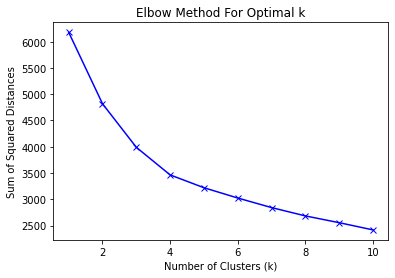

In [33]:
def plot_elbow_method(data, max_clusters):
    sum_of_squared_distances = []
    K = range(1, max_clusters + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans = kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Select only numeric columns for clustering
numeric_df = features_dataframe[numeric_columns]

# Plot the elbow method with a maximum number of clusters (e.g., 10)
plot_elbow_method(numeric_df, 10)

### The optimal number of clusters is where the WCSS starts to decrease
### at a lower rate, creating an "elbow" shape in the plot. <-- maybe 4?